<font size = "6"> Fordham Sports Analytics Society Big Data Bowl 2023 - Model Creation </font>

<font size = "4"> Build regression model to determine the distance of an individual rusher at the end of QB "Possession". </font>

- Authors:  Peter Majors, Chris Orlando, Jack Townsend, and Etienne Busnel
- Kaggle:  https://www.kaggle.com/competitions/nfl-big-data-bowl-2023/overview (Resources)
- Our Github:  https://github.com/peterlmajors/FSAS_BigDataBowl_2023 (Up-To-Date Code)

In [172]:
#Import Relevant Packages

#Data Manipulation
import pandas as pd
import numpy as np
from numpy import mean, std
import math

#Data Viz
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('ggplot')
import seaborn as sns 
import plotly.graph_objects as go

#SKLearn
import sklearn
from sklearn.metrics import get_scorer_names, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedKFold, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

#XGBoost
import xgboost as xgb
from xgboost import XGBRegressor, cv, plot_importance

#Statistics
from scipy.stats import pearsonr, spearmanr, uniform, randint

#Notebook Settings
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [211]:
#Import Model Ready Data
df = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/merged_data/df_model.csv")

#Create Feature List
df_features = ['s_rusher_ff_out_imm_zone', 's_rusher_ff_in_imm_zone', 'rusher_dist_from_qb_diff_beg_end_imm_zone', 'diff_btw_rusher_dir_blocker_o_ff_in_imm', 'blocker_o_diff_beg_end_imm_zone', 
               'time_rusher_in_imm_zone', 'time_in_imm_zone_after_out', 'rusher_avg_dist_from_qb_end_poss']
               
#Target Variable
df_target = ['rusher_dist_from_qb_end_poss']

<font size = "5"> Data Preprocessing (Null Values and One Hot Encoding) </font>

In [174]:
#Null Values
#Fill Time left In Immediate Zone Once Out As 0 If The Rusher Doesn't Re-Enter Or Never Leaves
df['time_in_imm_zone_after_out'] = df['time_in_imm_zone_after_out'].fillna(0)

<font size = "5"> Explore Relationships Between Features And Target Variable </font>

[Text(0.5, 1.0, 'Correlation Matrix of Continuous Variables')]

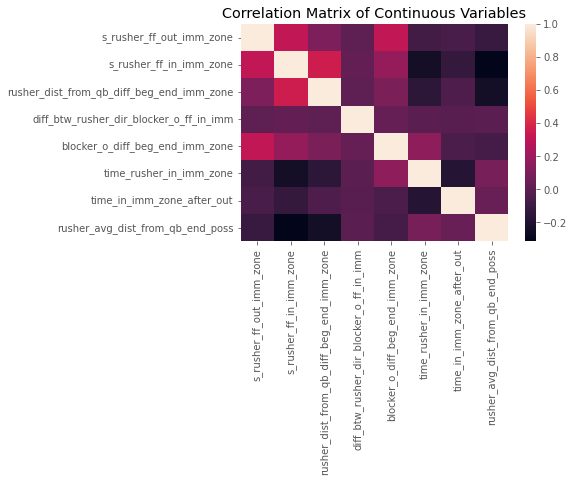

In [175]:
#Look At A Heatmap of Continuous Variables
sns.heatmap(df[df_features].corr()).set(title = "Correlation Matrix of Continuous Variables")

In [213]:
#Create Tackles & Guards and Centers DataFrames
df_t = df.loc[(df.pff_positionLinedUp == 'LT') | (df.pff_positionLinedUp == 'RT')]
df_gc = df.loc[(df.pff_positionLinedUp == 'C') | (df.pff_positionLinedUp == 'LG') | (df.pff_positionLinedUp == 'RG')]

In [177]:
#Categorical Values To Gropupby
# df.groupby('dropBackType')['rusher_dist_from_qb_end_poss'].mean()

#Cotinuous Correlations
# spearmanr(df.s_rusher_ff_imm_zone, df.rusher_dist_from_qb_end_poss)

<font size = '5' > Tackles Model Scaling and Fitting </font>

In [203]:
#Scaling On Tackles Data

#Standardize Continuous Values Around The Mean of 0
scaler = StandardScaler()
df_s_t = scaler.fit_transform(df_t[df_features])

#Turn It Back Into A Data Frame And Return Column Names
df_s_t = pd.DataFrame(df_s_t)
df_s_t.columns = df_features

In [204]:
#Prepare Features and Test/Train Split Manually (53% Train, 47% Test)

#Import The Standardized Tackle Data And Target Variables For Tackles
X_t = df_s_t[df_features]
y_t = df_t[df_target].reset_index(drop = True)

#Find Weeks For Plays In The Tackle Data
df_t_weeks = pd.DataFrame(df_t['week'].reset_index())

#Concat Onto X_t and y_t So Weeks Can Be Filtered
X_t = pd.concat([X_t, df_t_weeks], axis = 1, join = 'inner')
y_t = pd.concat([y_t, df_t_weeks], axis = 1, join = 'inner')

#Split Data By First Half/Second Half Of The Weeks To Make Model Interpretable Among Other Metrics

#Train Data (Wks 1-4)
X_train = X_t[X_t.week < 5]
y_train = y_t[y_t.week < 5]

#Test Data (Wks 5-8)
X_test = X_t[X_t.week > 4]
y_test = y_t[y_t.week > 4]

#Remove Unnecessary Columns
X_train, y_train, X_test, y_test = X_train[df_features], y_train[df_target], X_test[df_features], y_test[df_target]

#Check For Correct Shape
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8583, 8) (8583, 1) (7745, 8) (7745, 1)


In [205]:
#Study Hyperparameters Using Cross Validation

# #Assign Model
model_t = XGBRegressor(n_estimators= 75, max_depth=8, eta = .05, subsample = .9, colsample_bytree = .9)

# #Utilize Cross Validation To Further Enhance Model
cv = RepeatedKFold(n_splits=10, n_repeats=8, random_state=1)
scores = cross_val_score(model_t, X_train, y_train, cv=cv, scoring = 'neg_root_mean_squared_error', n_jobs = -1, error_score = 'raise')

# scores = abs(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: -2.119 (0.187)


In [201]:
#Update The Model Based On Cross Validation Tests and Fit and Balance Overfitting With Performance
model_t = XGBRegressor(objective = 'reg:squarederror', n_estimators= 75, max_depth = 8, eta = .05, subsample = .9, colsample_bytree = .9)
print("                 Test Set                        Train Set")
model_t.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)]) #Check For Overfitting

                 Test Set                        Train Set
[0]	validation_0-rmse:5.75256	validation_1-rmse:5.63532
[1]	validation_0-rmse:5.56412	validation_1-rmse:5.43695
[2]	validation_0-rmse:5.38863	validation_1-rmse:5.24908
[3]	validation_0-rmse:5.18050	validation_1-rmse:5.03521
[4]	validation_0-rmse:4.98527	validation_1-rmse:4.83367
[5]	validation_0-rmse:4.79934	validation_1-rmse:4.64170
[6]	validation_0-rmse:4.62524	validation_1-rmse:4.46219
[7]	validation_0-rmse:4.46397	validation_1-rmse:4.29376
[8]	validation_0-rmse:4.31204	validation_1-rmse:4.13191
[9]	validation_0-rmse:4.16896	validation_1-rmse:3.98079
[10]	validation_0-rmse:4.06435	validation_1-rmse:3.86353
[11]	validation_0-rmse:3.93949	validation_1-rmse:3.72785
[12]	validation_0-rmse:3.82275	validation_1-rmse:3.60092
[13]	validation_0-rmse:3.71209	validation_1-rmse:3.48052
[14]	validation_0-rmse:3.61133	validation_1-rmse:3.36807
[15]	validation_0-rmse:3.51654	validation_1-rmse:3.26302
[16]	validation_0-rmse:3.42834	validati

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=75, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [208]:
#Make Predictions On The Test Set

#Make Predictions On The Test Set
df_t_wks_5_8 = df_t[df_t.week > 4]
df_t_wks_5_8['pred_rusher_dist_from_qb_end_poss'] = model_t.predict(X_test)

#Calculate Mean Squared Error On Test Set
mse = mean_squared_error(y_test, df_t_wks_5_8.pred_rusher_dist_from_qb_end_poss)
r = spearmanr(df_t_wks_5_8.pred_rusher_dist_from_qb_end_poss, y_test)[0]
print(np.sqrt(mse), r)

2.2634701836534368 0.7759149225828881


C:\Users\Peter\AppData\Local\Temp\ipykernel_7648\1425817414.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_wks_5_8['pred_rusher_dist_from_qb_end_poss'] = model_t.predict(X_test)


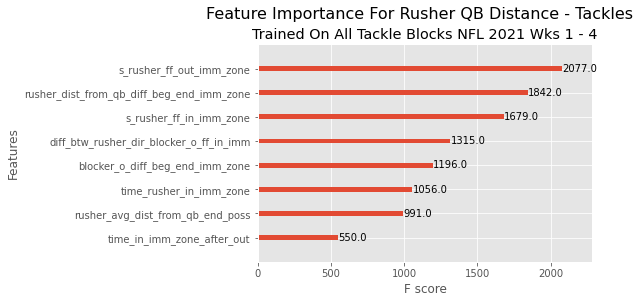

In [209]:
#Show Feature Importance
fig = plot_importance(model_t)
plt.title("Trained On All Tackle Blocks NFL 2021 Wks 1 - 4")
plt.suptitle('Feature Importance For Rusher QB Distance - Tackles', size = 16, y= 1.01)

plt.show()

<font size = '5' > Guards and Centers Model Scaling and Fitting </font>

In [214]:
#Scaling On Guards and Centers Data

#Standardize Continuous Values Around The Mean of 0
scaler = StandardScaler()
df_s_gc = scaler.fit_transform(df_gc[df_features])

#Turn It Back Into A Data Frame And Return Column Names
df_s_gc = pd.DataFrame(df_s_gc)
df_s_gc.columns = df_features

In [215]:
#Prepare Features and Test/Train Split Manually (53% Train, 47% Test)

#Import The Standardized Tackle Data And Target Variables For Tackles
X_gc = df_s_gc[df_features]
y_gc = df_gc[df_target].reset_index(drop = True)

#Find Weeks For Plays In The Tackle Data
df_gc_weeks = pd.DataFrame(df_gc['week'].reset_index())

#Concat Onto X_t and y_t So Weeks Can Be Filtered
X_gc = pd.concat([X_gc, df_gc_weeks], axis = 1, join = 'inner')
y_gc = pd.concat([y_gc, df_gc_weeks], axis = 1, join = 'inner')

#Split Data By First Half/Second Half Of The Weeks To Make Model Interpretable Among Other Metrics

#Train Data (Wks 1-4)
X_train = X_gc[X_gc.week < 5]
y_train = y_gc[y_gc.week < 5]

#Test Data (Wks 5-8)
X_test = X_gc[X_gc.week > 4]
y_test = y_gc[y_gc.week > 4]

#Remove Unnecessary Columns
X_train, y_train, X_test, y_test = X_train[df_features], y_train[df_target], X_test[df_features], y_test[df_target]

#Check For Correct Shape
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(12505, 8) (12505, 1) (11311, 8) (11311, 1)


In [220]:
#Study Hyperparameters Using Cross Validation

# #Assign Model
model_gc = XGBRegressor(objective = 'reg:linear', n_estimators= 50, max_depth=9, eta = .05, subsample = .6, colsample_bytree = .8)

# #Utilize Cross Validation To Further Enhance Model
cv = RepeatedKFold(n_splits=10, n_repeats=8, random_state=1)
scores = cross_val_score(model_gc, X_train, y_train, cv=cv, scoring = 'neg_root_mean_squared_error', n_jobs = -1, error_score = 'raise')

# scores = abs(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean RMSE: -2.343 (0.148)


In [221]:
#Update The Model Based On Cross Validation Tests and Fit and Balance Overfitting With Performance
model_gc = XGBRegressor(objective = 'reg:squarederror', n_estimators= 50, max_depth = 8, eta = .05, subsample = .9, colsample_bytree = 1)
print("                 Test Set                        Train Set")
model_gc.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)]) #Check For Overfitting

                 Test Set                        Train Set
[0]	validation_0-rmse:5.75284	validation_1-rmse:5.63355
[1]	validation_0-rmse:5.52141	validation_1-rmse:5.39721
[2]	validation_0-rmse:5.30092	validation_1-rmse:5.17370
[3]	validation_0-rmse:5.09705	validation_1-rmse:4.96288
[4]	validation_0-rmse:4.90399	validation_1-rmse:4.76415
[5]	validation_0-rmse:4.72474	validation_1-rmse:4.57652
[6]	validation_0-rmse:4.55521	validation_1-rmse:4.39936
[7]	validation_0-rmse:4.39741	validation_1-rmse:4.23212
[8]	validation_0-rmse:4.24950	validation_1-rmse:4.07384
[9]	validation_0-rmse:4.10936	validation_1-rmse:3.92611
[10]	validation_0-rmse:3.97664	validation_1-rmse:3.78640
[11]	validation_0-rmse:3.85333	validation_1-rmse:3.65378
[12]	validation_0-rmse:3.73884	validation_1-rmse:3.52924
[13]	validation_0-rmse:3.63161	validation_1-rmse:3.41246
[14]	validation_0-rmse:3.53311	validation_1-rmse:3.30215
[15]	validation_0-rmse:3.44151	validation_1-rmse:3.19869
[16]	validation_0-rmse:3.35828	validati

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.05,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [222]:
#Make Predictions On The Test Set
df_gc_wks_5_8 = df_gc[df_gc.week > 4]
df_gc_wks_5_8['pred_rusher_dist_from_qb_end_poss'] = model_gc.predict(X_test)

#Calculate Mean Squared Error On Test Set
mse = mean_squared_error(y_test, df_gc_wks_5_8.pred_rusher_dist_from_qb_end_poss)
r = spearmanr(df_gc_wks_5_8.pred_rusher_dist_from_qb_end_poss, y_test)[0]
print(np.sqrt(mse), r)

2.3998704169751606 0.7014012259486674


C:\Users\Peter\AppData\Local\Temp\ipykernel_7648\122287444.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gc_wks_5_8['pred_rusher_dist_from_qb_end_poss'] = model_gc.predict(X_test)


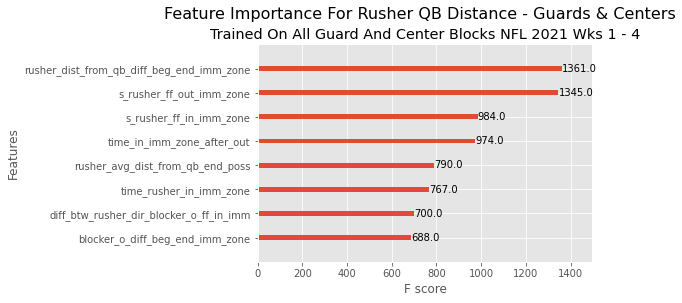

<Figure size 240x1600 with 0 Axes>

In [223]:
#Show Feature Importance
xgb.plot_importance(model_gc)
plt.title("Trained On All Guard And Center Blocks NFL 2021 Wks 1 - 4")
plt.suptitle('Feature Importance For Rusher QB Distance - Guards & Centers', size = 16, y= 1.01)
figure(figsize=(3, 20), dpi=80)
plt.show()

<font size = '5' > Evaluate Final Predictions </font>

In [224]:
#Apply Snap Threshold For Players

#Institute Minimum of Snaps For Tackles In Weeks 5-8 (Max 169) - 70 Snaps Includes Top 48 Players of 99 Total
df_t_wks_5_8_min = df_t_wks_5_8.groupby("displayName").count()['game_play_nfl_Id'].sort_values(ascending = False).reset_index()
df_t_wks_5_8_min = df_t_wks_5_8_min[df_t_wks_5_8_min.game_play_nfl_Id > 70]

#Institute Minimum of Snaps For Guards In Weeks 5-8 (Max 168) - 70 Snaps Includes Top 83 Players of 129 Total
df_gc_wks_5_8_min = df_gc_wks_5_8.groupby("displayName").count()['game_play_nfl_Id'].sort_values(ascending = False).reset_index()
df_gc_wks_5_8_min = df_gc_wks_5_8_min[df_gc_wks_5_8_min.game_play_nfl_Id > 70]

#Institute Minimum of Snaps For Tackles In Weeks 1-4 (Max 166) - 70 Snaps Includes Top 58 Players of 100 Total
df_t_wks_1_4 = df_t[df_t.week < 5]
df_t_wks_1_4_min = df_t_wks_1_4.groupby("displayName").count()['game_play_nfl_Id'].sort_values(ascending = False).reset_index()
df_t_wks_1_4_min = df_t_wks_1_4_min[df_t_wks_1_4_min.game_play_nfl_Id > 70]

#Institute Minimum of Snaps For Guards and Centers In Weeks 1-4 (Max 160) - 70 Snaps Includes Top 88 Players of 136 Total
df_gc_wks_1_4 = df_gc[df_gc.week < 5]
df_gc_wks_1_4_min = df_gc_wks_1_4.groupby("displayName").count()['game_play_nfl_Id'].sort_values(ascending = False).reset_index()
df_gc_wks_1_4_min = df_gc_wks_1_4_min[df_gc_wks_1_4_min.game_play_nfl_Id > 70]

print("\nWeeks 5-8 Thresholds")
print("Tackles", df_t_wks_5_8_min.shape, "Guards and Centers", df_gc_wks_5_8_min.shape)

print("\nWeeks 1-4 Thresholds")
print("Tackles", df_t_wks_1_4_min.shape, "Guards and Centers", df_gc_wks_1_4_min.shape)

#Tackles Threshold
df_t_min = df_t_wks_1_4_min.merge(df_t_wks_5_8_min, on = 'displayName', how = 'inner')
df_gc_min = df_gc_wks_1_4_min.merge(df_gc_wks_5_8_min, on = 'displayName', how = 'inner')

print("\nTotal Thresholds, Players Remaining")
print("Tackles", df_t_min.shape, "Guards and Centers", df_gc_min.shape)

#Merge These Onto Their Week 5-8 Data
# df_t_wks_5_8 = df_t_wks_5_8.merge(df_t_min, on = 'displayName', how = 'inner')
df_t_wks_5_8 = df_t_wks_5_8[df_t_wks_5_8['displayName'].isin(df_t_min['displayName'])]
# df_gc_wks_5_8 = df_gc_wks_5_8.merge(df_gc_min, on = 'displayName', how = 'inner')
df_gc_wks_5_8 = df_gc_wks_5_8[df_gc_wks_5_8['displayName'].isin(df_gc_min['displayName'])]

#Must Have 70 Plays In Weeks 1-4 and Weeks 5-8
#There Are Now 36 Tackles And 64 Guards/Centers In Considerations


Weeks 5-8 Thresholds
Tackles (59, 2) Guards and Centers (91, 2)

Weeks 1-4 Thresholds
Tackles (60, 2) Guards and Centers (94, 2)

Total Thresholds, Players Remaining
Tackles (43, 3) Guards and Centers (72, 3)


In [225]:
#Look At Best Tackles
pred_rusher_dist_from_qb_end_poss = df_t_wks_5_8.groupby("displayName")['pred_rusher_dist_from_qb_end_poss'].mean().sort_values().reset_index()
rusher_dist_from_qb_end_poss = df_t_wks_5_8.groupby("displayName")['rusher_dist_from_qb_end_poss'].mean().sort_values().reset_index()
df_tackles = pred_rusher_dist_from_qb_end_poss.merge(rusher_dist_from_qb_end_poss, on = 'displayName', how = 'inner')
df_tackles.sort_values(by = "pred_rusher_dist_from_qb_end_poss", ascending = False)

,displayName,pred_rusher_dist_from_qb_end_poss,rusher_dist_from_qb_end_poss
42,George Fant,6.003937,6.276241
41,Billy Turner,5.977477,5.963067
40,Tyron Smith,5.584477,5.865592
39,Kaleb McGary,5.529035,5.011357
38,Brian O'Neill,5.519106,5.404217
37,Rashawn Slater,5.408611,5.223242
36,Lucas Niang,5.404832,5.756966
35,Duane Brown,5.366941,5.535672
34,Orlando Brown,5.354177,6.124899
33,Cam Robinson,5.341019,6.041095


In [226]:
#Look At Best Predicted Guards/Centers In Football
pred_rusher_dist_from_qb_end_poss = df_gc_wks_5_8.groupby("displayName")['pred_rusher_dist_from_qb_end_poss'].mean().sort_values().reset_index()
rusher_dist_from_qb_end_poss = df_gc_wks_5_8.groupby("displayName")['rusher_dist_from_qb_end_poss'].mean().sort_values().reset_index()
df_gc = pred_rusher_dist_from_qb_end_poss.merge(rusher_dist_from_qb_end_poss, on = 'displayName', how = 'inner')
df_gc.sort_values(by = "pred_rusher_dist_from_qb_end_poss", ascending = False)

,displayName,pred_rusher_dist_from_qb_end_poss,rusher_dist_from_qb_end_poss
71,Ezra Cleveland,6.006997,6.229914
70,Garrett Bradbury,5.871661,5.751551
69,Olisaemeka Udoh,5.691372,5.964138
68,Creed Humphrey,5.610650,6.349286
67,Connor Williams,5.575167,5.597706
66,Ben Jones,5.521657,5.627421
65,Royce Newman,5.518612,5.850450
64,Sam Mustipher,5.497674,6.150202
63,Andrew Norwell,5.441063,6.146415
62,Zack Martin,5.351500,5.309658


Fit The Models On The Main Data Frame


figure out epa
look at distance and # of rushers (table)



box and whisker plot for model residuals

complete write up

moving immediate zone graphic

player by player and team by team rankings